In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.calibration import calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append('../')
from mimic.mimic_calibration import _MimicCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
from copy import copy

def calibration_comparison(base_estimator, n_samples, weights=None, n_bins= 10, detail=False):
    X, y = make_classification(n_samples=3*n_samples, 
                               n_features=6,
                               random_state=42, 
                               weights=weights)
    
    
    base_estimator_dict = {
        "MultinomialNB": MultinomialNB(),
        "GaussianNB": GaussianNB(),
        "SVC" : LinearSVC()
    }
    
    if (base_estimator == "MultinomialNB"):
        X -= X.min()
    # Train data: train binary model.
    X_train, y_train = X[:n_samples], y[:n_samples]
    print("Positive Rate: {x}".format(x = y_train.mean()))
    # calibrate data.
    X_calib, y_calib = X[n_samples:2 * n_samples], y[n_samples:2 * n_samples]
    # test data.
    X_test, y_test = X[2 * n_samples:], y[2 * n_samples:]
    
    
    
    # train the base estimator
    clf = base_estimator_dict[base_estimator].fit(X_train, y_train) # MultinomialNB().fit(X_train, y_train)
    
    
    if (base_estimator == "SVC"):
        # y_calib_score: training in the calibration model.
        y_calib_score = clf.decision_function(X_calib)
        y_calib_score = (y_calib_score - y_calib_score.min()) / (y_calib_score.max() - y_calib_score.min())
        # y_test_score: evaluation in the calibration model.
        y_test_score = clf.decision_function(X_test)
        y_test_score = (y_test_score - y_test_score.min()) / (y_test_score.max() - y_test_score.min())
    else:
        # y_calib_score: training in the calibration model.
        y_calib_score = clf.predict_proba(X_calib)
        y_calib_score = np.array([ score[1] for score in y_calib_score])

        # y_test_score: evaluation in the calibration model.
        y_test_score = clf.predict_proba(X_test)
        y_test_score = np.array([ score[1] for score in y_test_score])
    
    
    calibrate_model_dict = {
        "mimic": _MimicCalibration(threshold_pos=5, record_history=False),
        "isotonic": IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds='clip'),
        # "platt": LogisticRegression()
    }
    
    result = {}
    result[base_estimator] = {}
    for cal_name, cal_object in calibrate_model_dict.items():
        # import pdb; pdb.set_trace()
        print(cal_name)
        cal_object.fit(copy(y_calib_score), copy(y_calib))
        if cal_name in ["mimic", "isotonic"]:
            y_output_score = cal_object.predict(copy(y_test_score))
        else:
            raise "Please specify probability prediction function."
            
            
        frac_pos, predicted_value = calibration_curve(y_test, y_output_score, n_bins=n_bins)
        b_score = brier_score_loss(y_test, y_output_score, pos_label=1)
        # precsion = precision_score(y_test, y_output_score)
        # recall = recall_score(y_test, y_output_score)
        # f1 = f1_score(y_test, y_output_score)

        result[base_estimator][cal_name] = {
            "calibration_curve": [frac_pos, predicted_value],
            # "eval_score" : [b_score, precsion, recall, f1]
            "eval_score" : [b_score]
        }
        
        if (detail):
            result[base_estimator][cal_name]["detail"] = {
                "y_test": y_test,
                "y_test_calibrate_score": y_output_score
            }
            
        
    return result


In [5]:
def show_comparison_plots(base_estimator, n_samples, weights=None, n_bins=10, detail=False):
    
    res = calibration_comparison(base_estimator, n_samples, weights, n_bins, detail)
    all_calibration_methods = res[base_estimator]
    all_calibration_methods_names = list(all_calibration_methods.keys())
    color_map = {
       "isotonic": 'orangered',
        "mimic" : 'limegreen'
    }

    eval_df = []
    fig = plt.figure()
    for i, calib_name in enumerate(all_calibration_methods_names):
        
        frac_pos, predicted_value = all_calibration_methods[calib_name]["calibration_curve"]
        b_score = all_calibration_methods[calib_name]["eval_score"][0]

        # eval_df += [[base_estimator + "+" + calib_name, b_score, precsion, recall, f1]]
        if (i == 0):
            plt.plot(frac_pos,frac_pos,color ='grey',label = "perfect-calibration", alpha= 0.3, linewidth=5)

        plt.plot(predicted_value,
            frac_pos, 
            color = color_map[calib_name],label = "%s: %1.4f" % (calib_name, b_score), alpha= 0.7, linewidth=5)

    plt.legend(fontsize=20)
    plt.xlabel("calibrated probability", fontsize=18)
    plt.ylabel("fraction_of_positives", fontsize=18)
    # eval_df = pd.DataFrame(eval_df, columns = ["Model", "brier_score", "precsion", "recall", "f1"])
    # return eval_df
    return res, fig
        

Positive Rate: 0.5009
mimic
isotonic


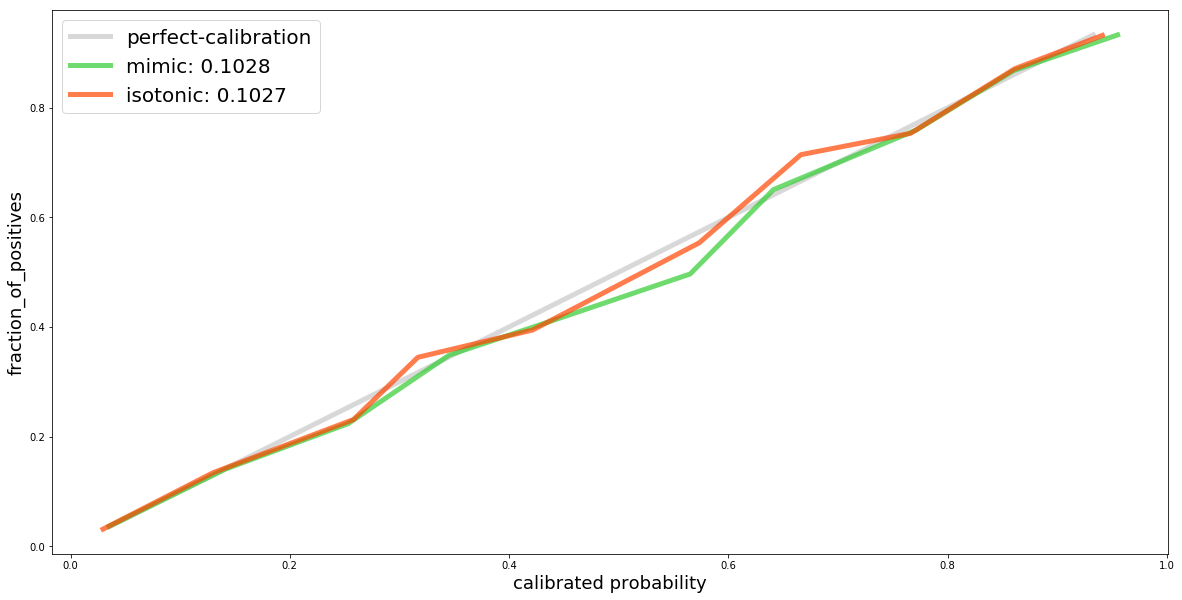

In [6]:
res, fig = show_comparison_plots("GaussianNB", 10000, None, 10)
fig.savefig("evaluation_calib_1.png")

Positive Rate: 0.5009
mimic
isotonic


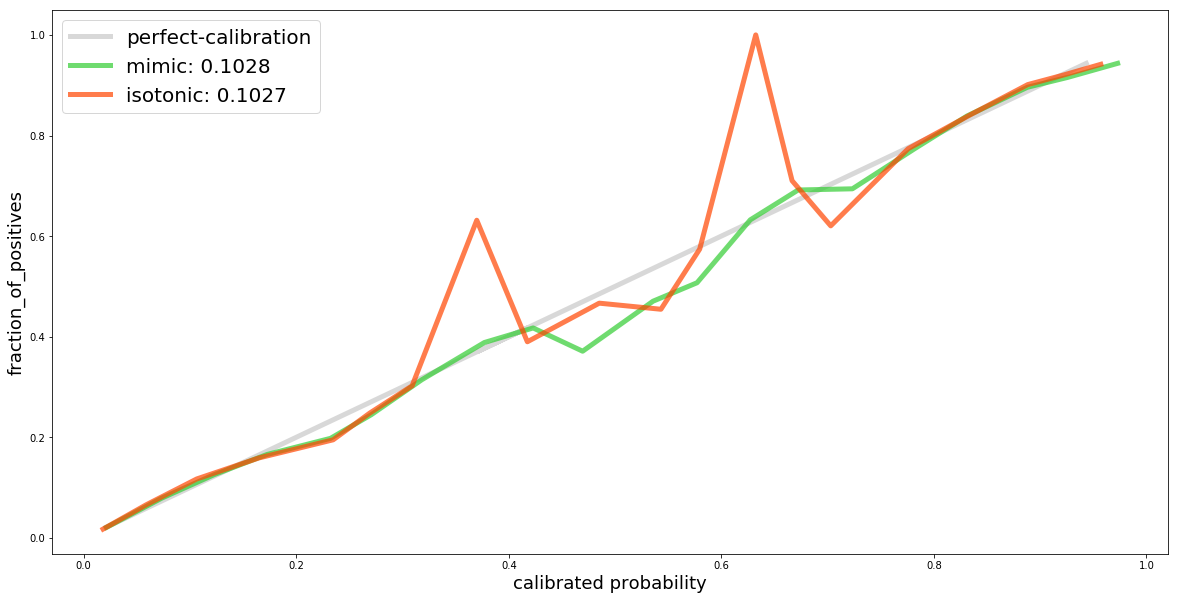

In [7]:
res2, fig2 = show_comparison_plots("GaussianNB", 10000, None, 20, True)
fig2.savefig("../data/evaluation_calib_2.png")

In [22]:
def calibrated_prob_space(res, cal_name="isotonic"):
    y_test = res['GaussianNB'][cal_name]['detail']['y_test']
    y_test_calibrate_score = res2['GaussianNB'][cal_name]['detail']['y_test_calibrate_score']
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_test_calibrate_score, bins) - 1
    df_detail = pd.DataFrame(
    data = {
        "y_test": y_test,
        "prob": y_test_calibrate_score,
        "bin" : binids
        }
    )
    df_detail["num"] = 1
    unique_prob_length = len(df_detail["prob"].unique())
    print("Unique of calibrated prob: {x} out of total data {y}".format(x = unique_prob_length, y = len(df_detail)))
    dgby = df_detail.groupby(["bin"]).agg({"y_test": "mean", "prob": "mean", "bin": sum})
    return df_detail, dgby

In [24]:
df_detail, dgby = calibrated_prob_space(res2, "isotonic")

Unique of calibrated prob: 96 out of total data 10000


In [25]:
df_detail, dgby = calibrated_prob_space(res2, "mimic")

Unique of calibrated prob: 8193 out of total data 10000
